In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta
from binance.client import Client
from analytic_function import get_stock
import pandas_bokeh
import analytic_function
import warnings
import os
import glob
import config
from strategy import profit_cumulative_calculation, advanced_analytics
warnings.filterwarnings('ignore')

In [3]:
# Parameters
binance_api_source_key = config.BINANCE_API_SOURCE_KEY
binance_api_sources_secret = config.BINANCE_API_SOURCE_SECRET
client = Client(binance_api_source_key, binance_api_sources_secret)
df = analytic_function.get_stock_bot("BATUSDT", '30m', "1 year ago UTC", 'Close_time')

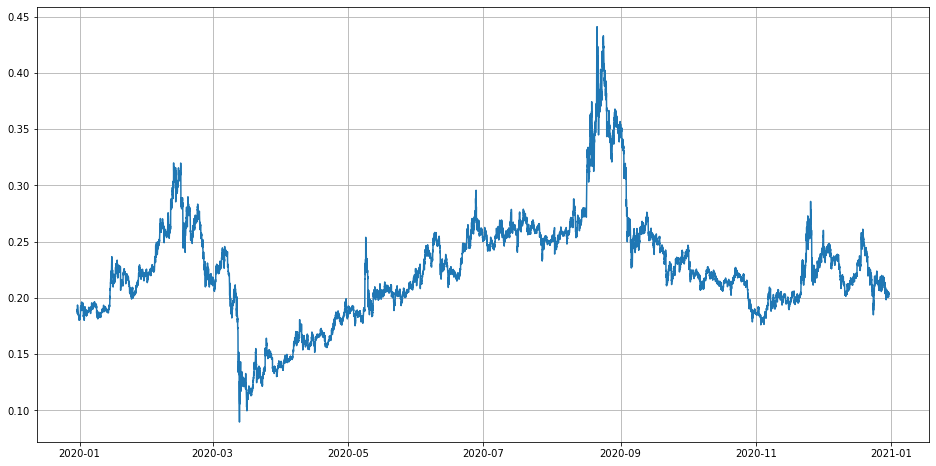

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.grid()

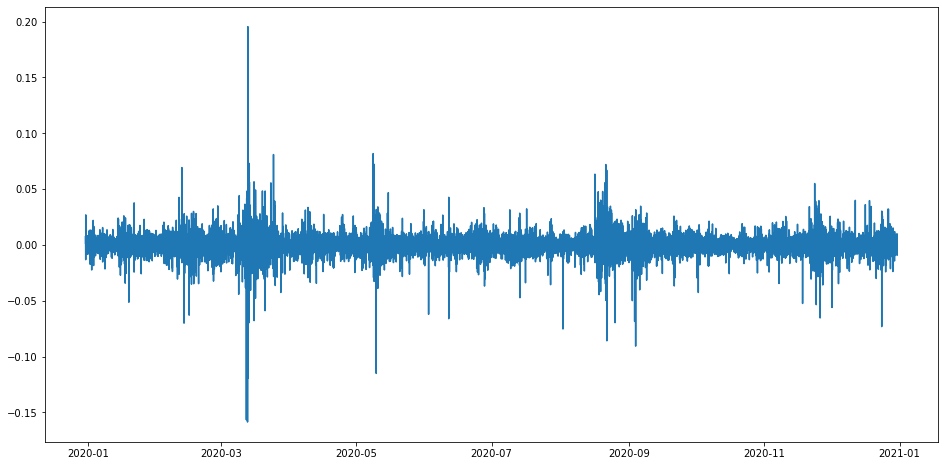

In [5]:
df['simple_rtn'] = df['Close'].pct_change()
plt.figure(figsize=(16,8))
plt.plot(df['simple_rtn'])

In [6]:
#df.iloc[0]

In [7]:
#df.iloc[-1]

In [8]:
df_rolling = df[['simple_rtn']].rolling(window=15).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_outliers = df.join(df_rolling)

In [9]:
def indentify_outliers(row, n_sigmas=3): 
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    #if (x > mu + 3 * sigma) | (x < mu - 3 * sigma): 
    #if (x > mu + 3 * sigma): 
    if (x < mu - 3 * sigma):
        
        
        return 1
    else:
        return 0

In [10]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]
outliers_index = outliers.index

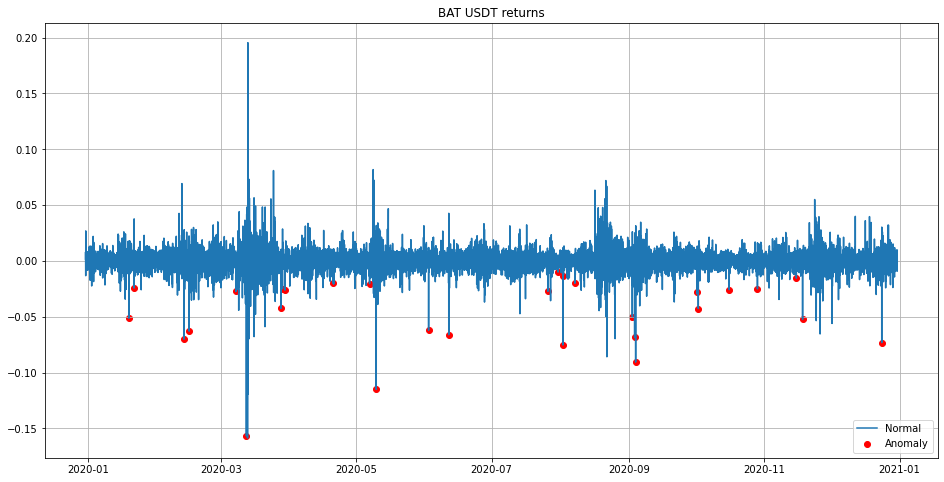

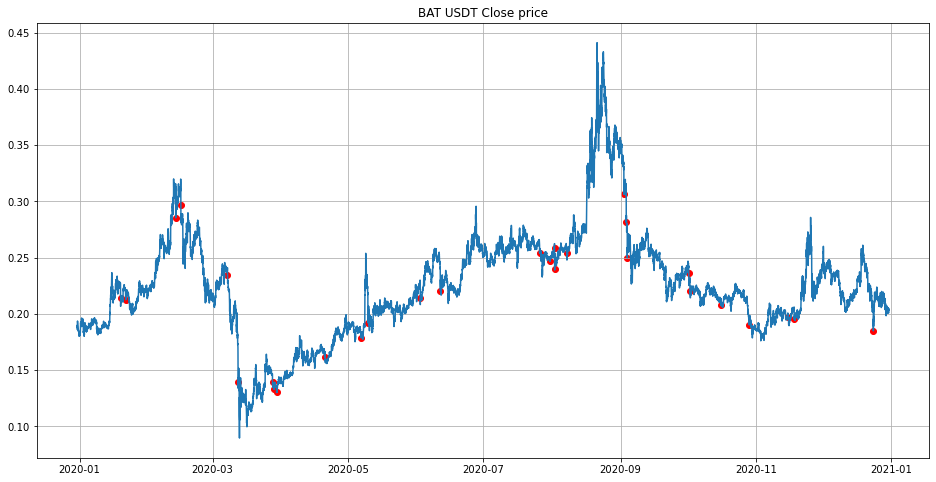

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df_outliers.index, df_outliers.simple_rtn, label='Normal')
plt.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
plt.title("BAT USDT returns") 
plt.legend(loc='lower right')
plt.grid()
plt.show()

df_outliers['Close'][outliers_index]
plt.figure(figsize=(16,8))
plt.plot(df['Close'],label='Close price')
plt.scatter(outliers_index, df_outliers['Close'][outliers_index],color='red', label='Anomaly')
plt.title("BAT USDT Close price")
plt.grid()
plt.show()

In [12]:
def strategy_outliers_sl_tp_cap_cumul(data,df_outliers, stopLoss, takeProfit):
    """ 
    BUY when fastperiod > slowperiod
    SELL when reach TP or SL or fastperiod < slowperiod
    Cumulative trading
    :param data: dataframe for a given coins
    :param type: dataframe
    :param tp: take profit in %
    :param type: float

    return buy_data, sell_data
    """

    
    sigPriceBuy=[]
    sigPriceSell=[]
    long_state = True
    short_state = False
    buy_status = False
    buy_price = 0
    price_sl = 0
    price_tp = 0
 
    print('Backtest..')
    print('----------')
    for i in range(len(data)):
        
        
        if df_outliers['outlier'][i] == 1 and long_state == True:
            
            
            sigPriceBuy.append(data['Close'][i])
            sigPriceSell.append(np.nan)
            long_state = False
            short_state = True
            buy_status = True
            
            buy_price = data['Close'][i]
            price_sl = buy_price - (buy_price * stopLoss)
            price_tp = buy_price + (buy_price * takeProfit)
            print("BUY: ", buy_price)
            print("SL:",price_sl )
            print("TP:",price_tp )


        
        elif data['Close'][i] <= price_sl and short_state == True:
             
            print('SL SELL:',data['Close'][i])
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data['Close'][i])
            long_state = True
            short_state = False
            buy_status = False
            print("---")
            
          
        elif data['Close'][i] >= price_tp and short_state == True:
               
            print('TP SELL:',data['Close'][i])
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data['Close'][i])
            buy_status = False
            short_state = False
            long_state = True
            print("---")
            
                
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    data['Buy_Signal_Price']=sigPriceBuy
    data['Sell_Signal_Price']=sigPriceSell
    # drop nan just to have serie of buy and sell price
    sell_data = data['Sell_Signal_Price'].dropna()
    buy_data = data['Buy_Signal_Price'].dropna()
    
    # Check if sell_data and sell_data are not empty 
    if len(sell_data) and len(buy_data):
        if sell_data.index[0] < buy_data.index[0] and buy_data.index[-1] > sell_data.index[-1]:
            sell_data = sell_data[1:]
            buy_data = buy_data[:-1]
           
        elif sell_data.index[0] < buy_data.index[0]: 
            buy_data=buy_data[1:]
            sell_data = sell_data[:-1]
        
        elif buy_data.index[-1] > sell_data.index[-1]:
            buy_data = buy_data[:-1]

    return buy_data, sell_data


In [13]:
symbol = "BATUSDT"
amount = 100
fees = 0.001
kline = '1h'
buy_data, sell_data = strategy_outliers_sl_tp_cap_cumul(df, df_outliers, stopLoss=0.08, takeProfit=0.07)

Backtest..
----------
BUY:  0.2144
SL: 0.197248
TP: 0.229408
TP SELL: 0.2295
---
BUY:  0.2853
SL: 0.262476
TP: 0.305271
TP SELL: 0.3072
---
BUY:  0.2964
SL: 0.272688
TP: 0.317148
SL SELL: 0.2719
---
BUY:  0.2344
SL: 0.215648
TP: 0.250808
SL SELL: 0.2146
---
BUY:  0.1394
SL: 0.128248
TP: 0.14915799999999999
TP SELL: 0.1499
---
BUY:  0.1393
SL: 0.128156
TP: 0.14905100000000002
TP SELL: 0.1496
---
BUY:  0.1615
SL: 0.14858
TP: 0.17280500000000001
TP SELL: 0.1732
---
BUY:  0.1785
SL: 0.16422
TP: 0.190995
TP SELL: 0.1912
---
BUY:  0.1922
SL: 0.176824
TP: 0.205654
TP SELL: 0.2068
---
BUY:  0.2143
SL: 0.197156
TP: 0.22930099999999998
TP SELL: 0.2321
---
BUY:  0.2204
SL: 0.202768
TP: 0.235828
TP SELL: 0.2375
---
BUY:  0.254
SL: 0.23368
TP: 0.27178
SL SELL: 0.2327
---
BUY:  0.2471
SL: 0.22733199999999998
TP: 0.264397
TP SELL: 0.2646
---
BUY:  0.3062
SL: 0.281704
TP: 0.32763400000000004
SL SELL: 0.2813
---
BUY:  0.2498
SL: 0.229816
TP: 0.267286
TP SELL: 0.2675
---
BUY:  0.236
SL: 0.21711999999999

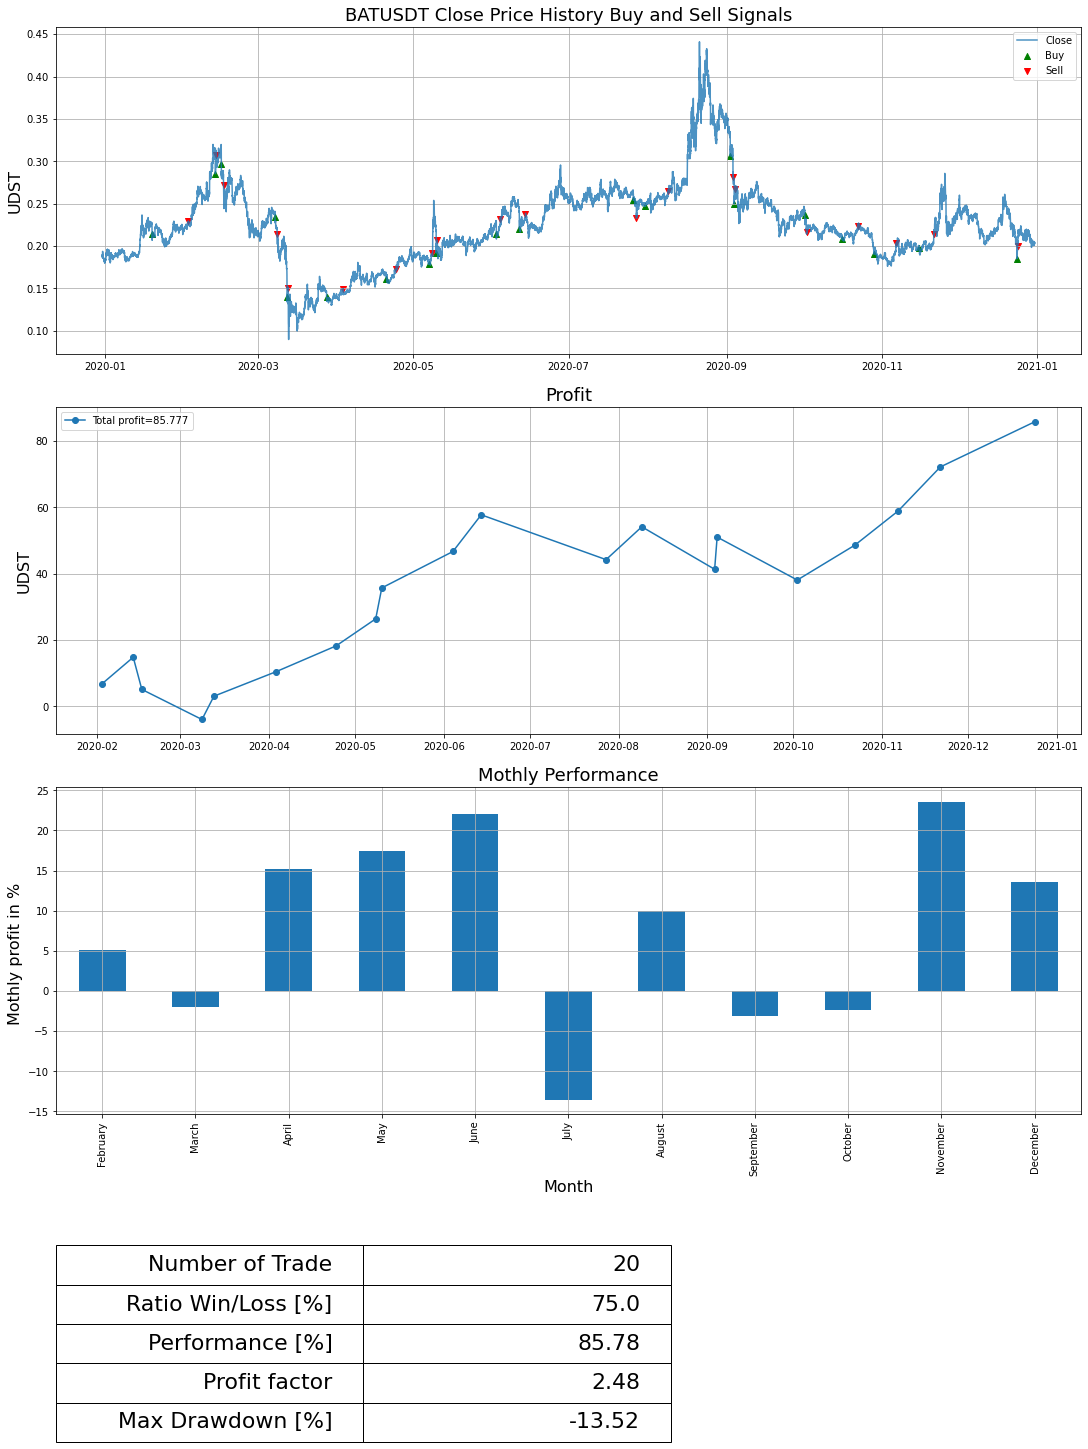

In [14]:
profit = profit_cumulative_calculation(amount=amount, fees=fees ,buy_price=buy_data, sell_price=sell_data, verbose = False)     
analytical_df = advanced_analytics(data= df,buy_data=buy_data,sell_data=sell_data,
                                                        symbol=symbol, kline=kline, 
                                                        profit= profit, show_plot=True, 
                                                        save_plot=False, path = False)